### Visualizing the distribution of the observations

### Load the required libraries

In [4]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='SSSSSSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12836
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    13|[B0 58 A0 57 28 5...|1970.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    14|[10 5A 08 59 30 5...|1971.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    46|[E8 59 40 5A 38 5...|1972.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    18|[A0 56 B0 58 B0 5...|1973.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    21|[E0 58 40 56 58 5...|1974.0|SSSSSSBB|
+---------+--------+---------+-----------+-----------+------+-------------

In [5]:
#df.show(100)

### Select data for a particular station and measurement type

In [6]:
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00023852')
Query="SELECT Min(latitude), Min(longitude), Max(latitude), Max(longitude) FROM weather"
print Query
df1 = sqlContext.sql(Query)
df1.show()

SELECT Min(latitude), Min(longitude), Max(latitude), Max(longitude) FROM weather
+-------------+--------------+-------------+--------------+
|min(latitude)|min(longitude)|max(latitude)|max(longitude)|
+-------------+--------------+-------------+--------------+
|      33.3369|     -116.5833|      34.1158|     -111.7432|
+-------------+--------------+-------------+--------------+



In [19]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('TOBS')
#Query="SELECT Min(latitude), Min(longitude), Max(latitude), Max(longitude) FROM weather"
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(10)

SELECT * FROM weather
	WHERE measurement='TOBS'
1271 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     7|[40 56 E0 50 00 5...|1970.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     3|[A0 56 30 55 80 5...|1971.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    14|[80 54 A0 53 F0 5...|1973.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    10|[40 56 20 50 30 5...|1974.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     8|[30 54 30 54 30 5...|1975.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     8|[00 4F 80 51 30 5...|1976.0|SSSSSSBB|
|    360.0| 33.3833|-111.9333|       TOBS|USC000284

In [49]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('TMAX')
#Query="SELECT vector FROM weather\n\tWHERE measurement='%s'"%('TMAX')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates

Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('TMIN')
#Query="SELECT vector FROM weather\n\tWHERE measurement='%s'"%('TMAX')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T1=np.vstack(rows)
T1=T1/10.  # scaling to make the temperature be in centingrates

Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('TOBS')
#Query="SELECT vector FROM weather\n\tWHERE measurement='%s'"%('TMAX')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T2=np.vstack(rows)
T2=T2/10.  # scaling to make the temperature be in centingrates

shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX'
2108 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    13|[B0 58 A0 57 28 5...|1970.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TMAX|USC00023852|    14|[10 5A 08 59 30 5...|1971.0|SSSSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

SELECT * FROM weather
	WHERE measurement='TMIN'
1984 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+------

(2108, 365)

### Script for plotting yearly plots

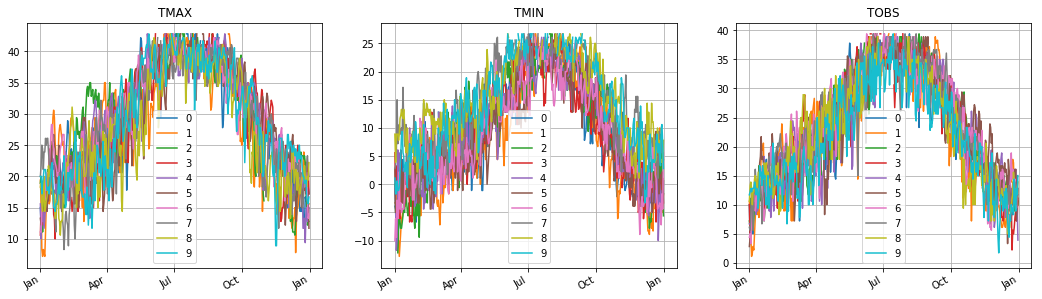

In [57]:
from YearPlotter import YearPlotter
#fig, ax = plt.subplots(figsize=(12,9));
#plot_pair(['TMAX', 'TMIN'], plot_valid)
fig,X=subplots(1,3,figsize=(18,5))
axes=X.reshape(3)

YP=YearPlotter()
YP.plot(T[:10,:].transpose(),fig,axes[0],title='TMAX')
YP.plot(T1[:10,:].transpose(),fig,axes[1],title='TMIN')
YP.plot(T2[:10,:].transpose(),fig,axes[2],title='TOBS')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [54]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,3,figsize=(15,4))
    axes=X.reshape(3)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

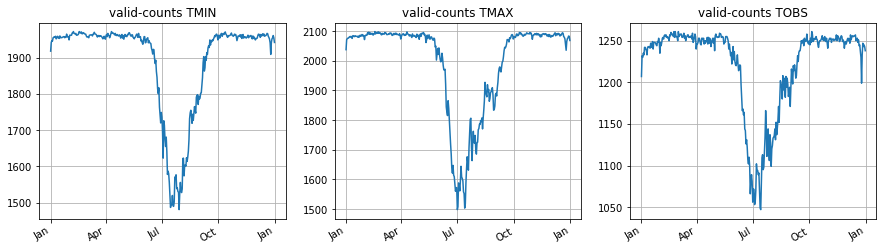

In [55]:
plot_pair(['TMIN','TMAX', 'TOBS'],plot_valid)

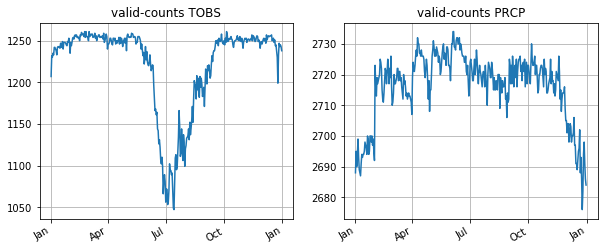

In [8]:
plot_pair(['TOBS','PRCP'],plot_valid)

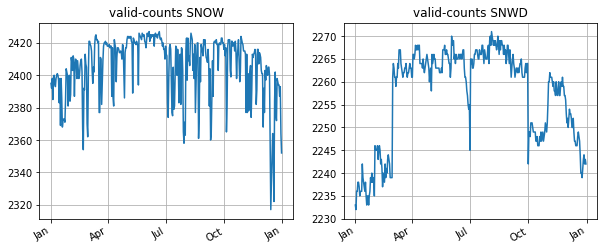

In [9]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [10]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([(mean-std)/10.,mean/10.,(mean+std)/10.]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

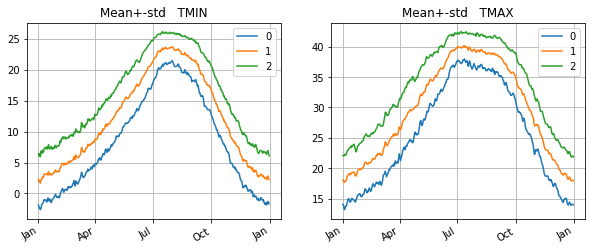

In [11]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

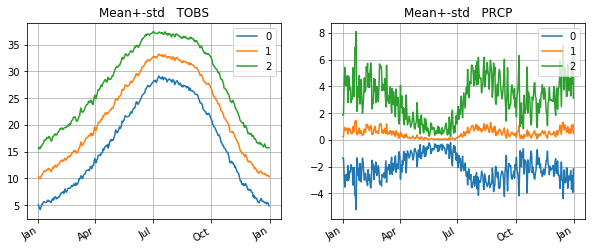

In [12]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

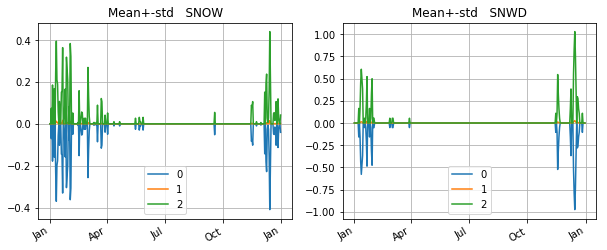

In [13]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [14]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

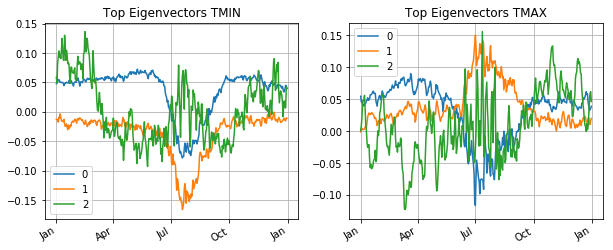

In [15]:
plot_pair(['TMIN','TMAX'],plot_eigen)

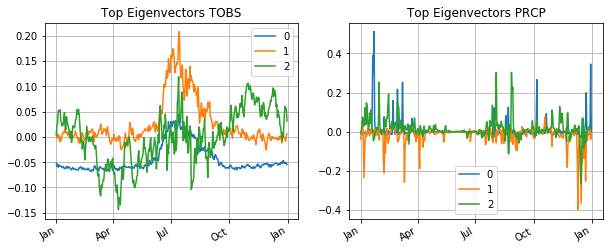

In [16]:
plot_pair(['TOBS','PRCP'],plot_eigen)

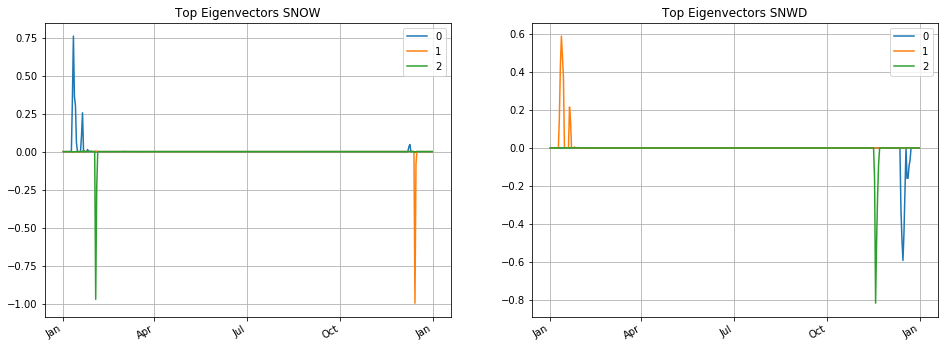

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [19]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=20
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

In [20]:
STAT['TMAX']['eigval']

array([  9.26578788e+04,  -9.53123394e+04,   3.52384572e+04,
         3.12911619e+04,  -2.13535646e+04,  -1.85206315e+04,
        -1.87878147e+04,   2.75627297e+04,   2.55824248e+04,
         2.31473635e+04,   2.21951425e+04,   2.19704230e+04,
         2.05008483e+04,   2.00379809e+04,   1.94969158e+04,
         1.83519043e+04,   1.76140108e+04,   1.65140536e+04,
        -1.37787956e+04,  -1.27413156e+04,  -1.21572837e+04,
        -1.07254843e+04,   1.61132569e+04,   1.53082602e+04,
        -9.06450883e+03,  -8.91527792e+03,  -8.20631746e+03,
         1.37872095e+04,   1.33901321e+04,  -7.29304511e+03,
        -7.03222157e+03,   1.30580268e+04,   1.26466651e+04,
         1.21006433e+04,   1.16719057e+04,  -6.17629700e+03,
         1.10996423e+04,   1.08305016e+04,   1.02731619e+04,
         9.80317975e+03,   9.33415827e+03,   8.87700576e+03,
         8.60870560e+03,   8.41178181e+03,   8.02373217e+03,
         7.92248939e+03,   7.57526318e+03,   7.01135042e+03,
        -5.51982638e+03,

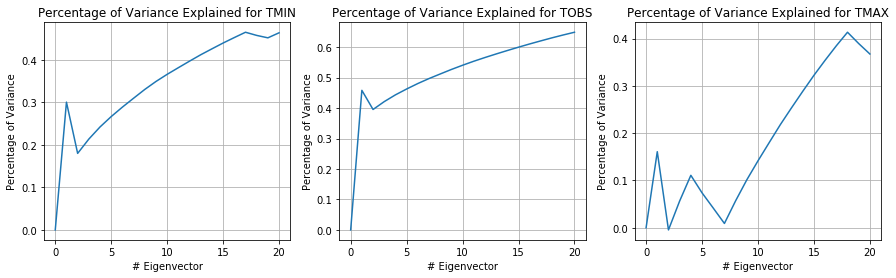

In [21]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

In [28]:
#STAT['TMAX']['eigval']

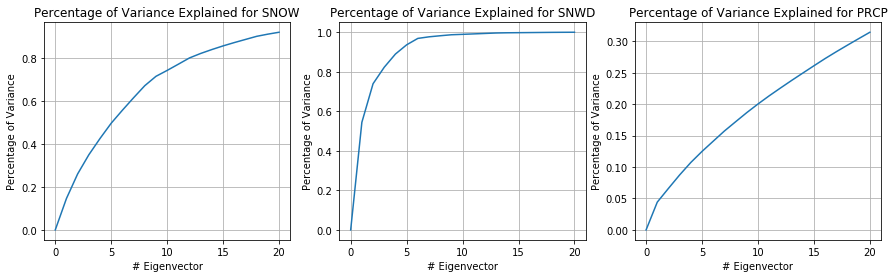

In [23]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()